In [36]:
import kwant

# For plotting
#from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

import tinyarray  

# define Pauli matrix 
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])  
sigma_z = tinyarray.array([[1, 0], [0, -1]])

a=1  # lattice constant

# QAH insulators

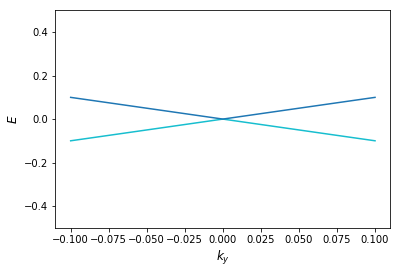

In [37]:
hamiltonian = """
            (m+B*(k_x**2+k_y**2))*sigma_z+A*k_x*sigma_x+A*k_y*sigma_y
    """
params = dict(A = 1, B = 1, m=-2)

template = kwant.continuum.discretize(hamiltonian, grid_spacing=a)

Ly=50 #size of system
Lx=40

def shape(site):
    (x, y) = site.pos
    return (0 <= y < Ly and 0 <= x < Lx)

def lead_shape(site): 
    (x, y) = site.pos
    return (0 <= x < Lx)

syst = kwant.Builder()
syst.fill(template, shape, (0, 0))

lead = kwant.Builder(kwant.TranslationalSymmetry([0, -a]))
lead.fill(template, lead_shape, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

#kwant.plot(syst)  # plot system if necessary
    
#energy dispersion
bands = kwant.physics.Bands(syst.leads[0], params=params)
momenta = np.linspace(-0.1, 0.1, 101)
energies = [bands(k) for k in momenta]

# group velocity of edge states
slop = []
for i in range(np.int_((len(momenta)+1)/2),len(momenta)): #for zero momentum to larger ones
    slop.append(energies[i][np.int_(len(energies[i])/2)] / momenta[i])
    
#print(slop)    
    
#plot band structure
plt.plot(momenta, energies)
plt.xlabel('$k_y$', fontsize='large')
plt.ylabel('$E$', fontsize='large')
plt.ylim(-0.5, 0.5)
plt.show()

# QAH insulator with s-wave superconductivity

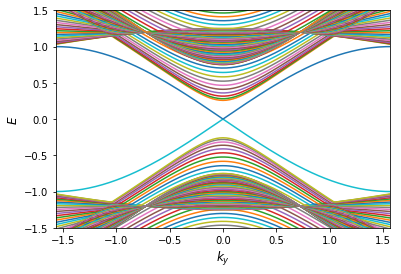

In [39]:
hamiltonian = """
            (m+B*(k_x**2+k_y**2))*kron(sigma_z,sigma_z)
            -mu*kron(sigma_0,sigma_z)
            +A*k_x*kron(sigma_x,sigma_0)
            +A*k_y*kron(sigma_y,sigma_z)
            -delta*kron(sigma_y,sigma_y)
    """

params = dict(A = 1, B = 0.5, m=-0.5, mu=0., delta=0.75)  #sigma is no need to input

template = kwant.continuum.discretize(hamiltonian, grid_spacing=a)

Lx=50

def lead_shape(site): 
    (x, y) = site.pos
    return (0 <= x < Lx)

lead = kwant.Builder(kwant.TranslationalSymmetry([0, -a]))
lead.fill(template, lead_shape, (0, 0))

syst = lead.finalized()

#kwant.plot(syst)
    
#band structure
bands = kwant.physics.Bands(syst, params=params)
momenta = np.linspace(-np.pi/2, np.pi/2, 201)
energies = [bands(k) for k in momenta]



# group velocity of edge states
slop = []
for i in range(np.int_((len(momenta)+1)/2),len(momenta)): #for zero momentum to larger ones
    slop.append(energies[i][np.int_(len(energies[i])/2)] / momenta[i])
    
#print(slop)    
    
#plot band structure
plt.plot(momenta, energies)
plt.xlabel('$k_y$', fontsize='large')
plt.ylabel('$E$', fontsize='large')
plt.ylim(-1.5, 1.5)
plt.xlim(-np.pi/2, np.pi/2)
plt.show()


# Wave functions of edge states in QAH with s-wave SC

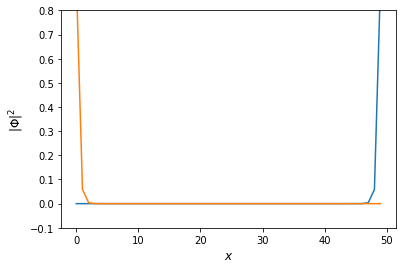

In [46]:
hopping = syst.inter_cell_hopping(params=params)
onsite = syst.cell_hamiltonian(params=params)

ham = lambda k: hopping*np.exp(-1j*k) + hopping.T.conj()*np.exp(1j*k) + onsite  #build hamiltonian

ky = 0.001
evals, evecs = np.linalg.eigh(ham(ky))  

Ecut = 0.01
zeros = (np.abs(evals)<Ecut) # using energy cutoff to pick edge modes

edge_states = evecs[:, zeros]

edge_states.shape

#wavefunction for edge 1
dens1 = np.abs(edge_states[:, 0])**2
dens1 = np.split(dens1, Lx)
dens1 = np.array([sum(site) for site in dens1])

#wavefunction for edge 2
dens2 = np.abs(edge_states[:, 1])**2
dens2 = np.split(dens2, Lx)
dens2 = np.array([sum(site) for site in dens2])

#plot wavefunctions
plt.ylim(-0.1, 0.8)
plt.xlabel('$x$', fontsize='large')
plt.ylabel('$|\Phi|^2$', fontsize='large')
plt.plot(dens1)
plt.plot(dens2)